# White Blood Cell Image Classification
### By [Anthony Medina](https://www.linkedin.com/in/anthony-medina-math/)

# Modeling Notebook
1. Notebook Objectives
2. Imports
3. Final Pre-Building Checks
4. Model 1 Neural Network
5. Model 2 Random Forest
6. Model 3 Gradient Boosting Machine
7. Model results analysis
8. Model Choice
9. Next Steps

### 1. Notebook Objectives

This notebook will house the model building, evaluation of each model, and picking the model with best Recall score.

### 2. Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

2023-09-01 21:54:30.684746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../cleaned_data/cleaned_data.csv')
df.head()

,cell_key,image_array
0,0,[0.01176471 0. 0. ... 0. ...
1,0,[0. 0. 0. ... 0.760784...
2,0,[0. 0. 0. ... 0. 0. 0.]
3,0,[0. 0. 0. ... 0.764705...
4,0,[0. 0. 0. ... 0. 0. 0.]


In [3]:
df.dtypes

cell_key        int64
image_array    object
dtype: object

In [4]:
df['image_array'] = df['image_array'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

/var/folders/b0/x4p60r3n3dz3lbgp1_bgg05h0000gn/T/ipykernel_77583/3068472533.py:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  df['image_array'] = df['image_array'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))


In [5]:
df.dtypes

cell_key        int64
image_array    object
dtype: object

### 3. Data Split

In [6]:
X = np.array(df['image_array'].tolist())
y = np.array(df['cell_key'])
recall_list = []
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
np.max(y_train)

3

### 4. Model 1 Neural Network

/var/folders/b0/x4p60r3n3dz3lbgp1_bgg05h0000gn/T/ipykernel_77583/2439174499.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs = 10, batch_size = 32, verbose=0)
2023-09-01 21:54:36.028089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


389/389 [==============================] - 0s 580us/step


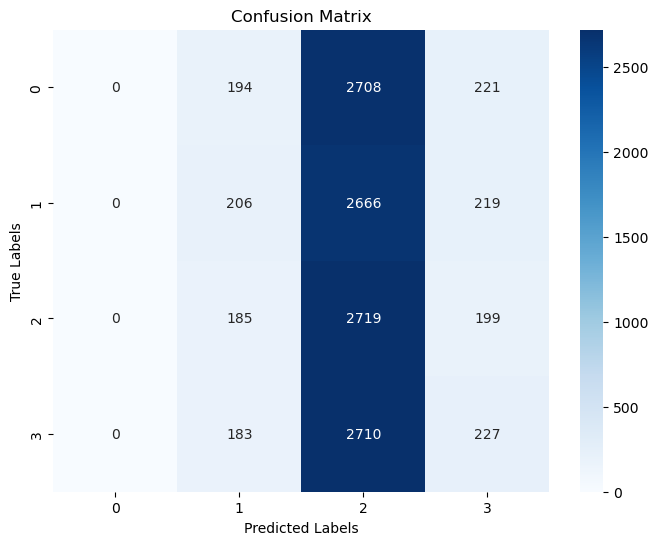

Best Parameters: {'batch_size': 64, 'epochs': 50}
Test Recall: 0.2532059549146506


In [8]:
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(num_features,)),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define constants
num_features = X_train.shape[1]
num_classes = np.max(y_train) + 1  # Assuming class labels start from 0

# Create a KerasClassifier based on the create_model function
model = KerasClassifier(build_fn=create_model, epochs = 10, batch_size = 32, verbose=0)

# Define the parameter grid for grid search
param_grid = {
    'epochs': [10, 20, 50],
    'batch_size': [32, 64],
}

# Define the scoring function (recall)
scoring = make_scorer(recall_score, average='macro')

# Initialize Kfold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=kfold)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator from grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on your test data
y_pred = best_model.predict(X_test)
recall = recall_score(y_test, y_pred, average='macro')


y_pred2 = best_model.predict(X)
cm = confusion_matrix(y, y_pred2)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("Best Parameters:", best_params)
print("Test Recall:", recall)
recall_list.append(recall)


### Best Neural Network

In [9]:
"""import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the best hyperparameters
best_hidden_units = 128
best_activation = 'relu'
best_optimizer = 'adam'
best_loss = 'categorical_crossentropy'
best_epochs = 50
best_batch_size = 32

# Load and preprocess data
X_train, y_train = load_and_preprocess_data()

# Build the final model
final_model = Sequential([
    Dense(best_hidden_units, activation=best_activation, input_shape=(input_shape,)),
    Dense(output_units, activation='softmax')
])

# Compile the model
final_model.compile(optimizer=best_optimizer, loss=best_loss, metrics=['accuracy'])

# Train the final model
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Evaluate the final model on validation/test data
validation_accuracy = final_model.evaluate(X_validation, y_validation)[1]

# Save the final model
final_model.save('final_model.h5')


"""

"import numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\n\n# Define the best hyperparameters\nbest_hidden_units = 128\nbest_activation = 'relu'\nbest_optimizer = 'adam'\nbest_loss = 'categorical_crossentropy'\nbest_epochs = 50\nbest_batch_size = 32\n\n# Load and preprocess data\nX_train, y_train = load_and_preprocess_data()\n\n# Build the final model\nfinal_model = Sequential([\n    Dense(best_hidden_units, activation=best_activation, input_shape=(input_shape,)),\n    Dense(output_units, activation='softmax')\n])\n\n# Compile the model\nfinal_model.compile(optimizer=best_optimizer, loss=best_loss, metrics=['accuracy'])\n\n# Train the final model\nfinal_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)\n\n# Evaluate the final model on validation/test data\nvalidation_accuracy = final_model.evaluate(X_validation, y_validation)[1]\n\n# Save the final model\nfinal_model.save('final_mod

### 5. Model 2 Random Forest

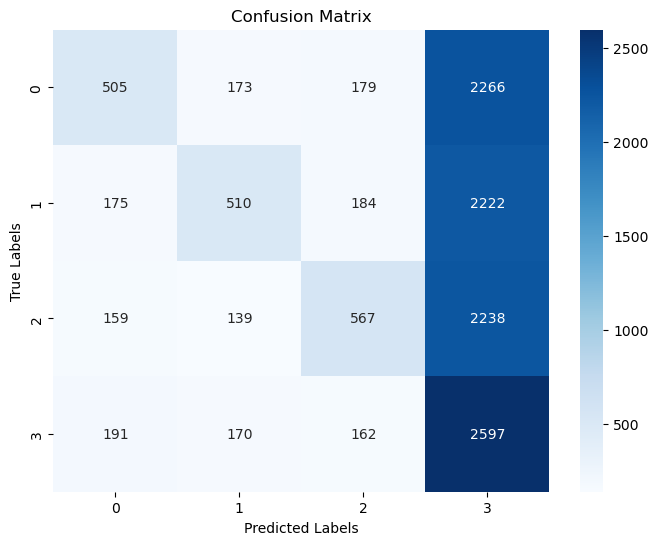

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Test Recall: 0.2558081272080904


In [10]:
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the scoring function (recall)
scoring = make_scorer(recall_score, average='macro')

# Initialize KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=kfold, scoring=scoring)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator from grid search
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Evaluate the best model on your test data
y_pred = best_rf.predict(X_test)
recall = recall_score(y_test, y_pred, average='macro')



y_pred2 = best_rf.predict(X)
cm = confusion_matrix(y, y_pred2)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("Best Parameters:", best_params)
print("Test Recall:", recall)
recall_list.append(recall)

In [11]:
### Best Random Forest

### 6. Model 3 Gradient Boosting Machine

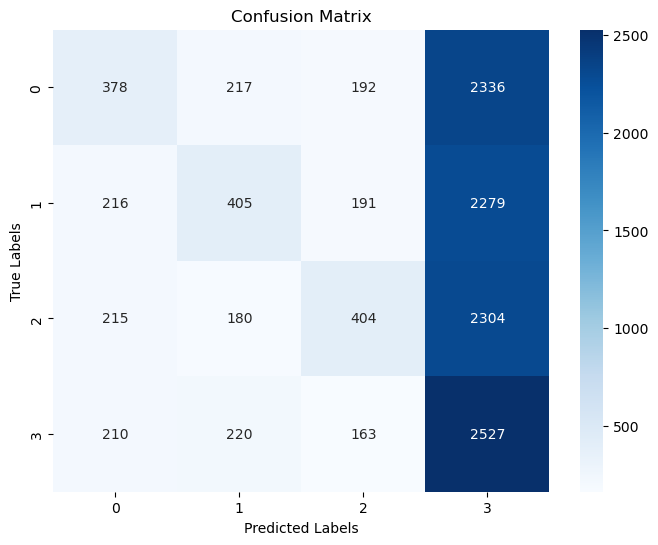

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Test Recall: 0.24676271175397926


In [12]:
# Define the Gradient Boosting classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Define the scoring function (recall)
scoring = make_scorer(recall_score, average='macro')

# Initialize Kfold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(gbm_classifier, param_grid, scoring=scoring, cv=kfold)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator from grid search
best_params = grid_search.best_params_
best_gbm = grid_search.best_estimator_

# Evaluate the best model on your test data
y_pred = best_gbm.predict(X_test)
recall = recall_score(y_test, y_pred, average='macro')


y_pred2 = best_gbm.predict(X)
cm = confusion_matrix(y, y_pred2)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("Best Parameters:", best_params)
print("Test Recall:", recall)
recall_list.append(recall)

In [13]:
### Best Gradient Boosting Machine

### 7. Model results analysis

In [14]:
print('All Model Scores', recall_list)

All Model Scores [0.2532059549146506, 0.2558081272080904, 0.24676271175397926]


### 8. Model Choice

In [15]:
max_index = recall_list.index(max(recall_list))
print('The model with the best score was model number', max_index + 1, '.')

The model with the best score was model number 2 .


## The best model

### 9. Next Steps


Create a final model using the best parameters from the random forest model